### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/west_virginia/2023_07_14_09_41_21/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/west_virginia/2023_07_14_09_41_21/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,Female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0
1,1,Female,2023,acute_ischemic_stroke,deaths,29,lifestyle_100,25_to_29,0
2,2,Female,2023,acute_ischemic_stroke,deaths,29,outreach_100,25_to_29,0
3,3,Female,2023,acute_ischemic_stroke,deaths,29,polypill_100,25_to_29,0
4,4,Female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0


In [5]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

157447581.5468857

### Total DALYs by Year

In [6]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,Female,25_to_29,29,2023,3010.497701,42.758147,3053.255848
1,Female,25_to_29,29,2024,2713.681951,55.954706,2769.636657
2,Female,25_to_29,29,2025,2740.111283,65.689157,2805.800440
3,Female,25_to_29,29,2026,1969.923438,65.940702,2035.864140
4,Female,25_to_29,29,2027,2459.660322,68.570687,2528.231009


In [7]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,10593.449235,1770.229223,23964.855726
1,2024,10591.482244,1595.926695,24765.478834
2,2025,10826.412122,1730.973741,24185.152752
3,2026,10819.709273,1751.751906,25194.872145
4,2027,10737.178115,1683.695421,25079.418637


### All Cause Mortality Graphs

In [8]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,1.250000,0.0,5.050
1,25_to_29,Female,2024,1.400000,0.0,7.000
2,25_to_29,Female,2025,1.021875,0.0,5.050
3,25_to_29,Female,2026,1.278125,0.0,7.075
4,25_to_29,Female,2027,1.359375,0.0,9.050


#### All Cause Mortality Graph with Rate

In [9]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,Female,2023,29,37209.144422
1,25_to_29,Female,2023,232,37086.795346
2,25_to_29,Female,2023,357,37485.733060
3,25_to_29,Female,2023,394,37356.637919
4,25_to_29,Female,2023,602,37300.829569


In [10]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.001071,0.000559,0.002155
1,25_to_29,Female,2024,0.001212,0.000452,0.002970
2,25_to_29,Female,2025,0.000893,0.000266,0.002044
3,25_to_29,Female,2026,0.001122,0.000401,0.003280
4,25_to_29,Female,2027,0.001191,0.000569,0.002711


### Cause Specific Mortality Graphs
#### Acute Stroke

In [11]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,Female,2023,acute_ischemic_stroke,0.0,0.0,0.0
1,8,25_to_29,Female,2024,acute_ischemic_stroke,0.1,0.0,1.0
2,16,25_to_29,Female,2025,acute_ischemic_stroke,0.1,0.0,1.0
3,24,25_to_29,Female,2026,acute_ischemic_stroke,0.0,0.0,0.0
4,32,25_to_29,Female,2027,acute_ischemic_stroke,0.2,0.0,2.0


In [12]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,Female,2023,29,acute_ischemic_stroke,0
1,8,25_to_29,Female,2023,232,acute_ischemic_stroke,0
2,16,25_to_29,Female,2023,357,acute_ischemic_stroke,0
3,24,25_to_29,Female,2023,394,acute_ischemic_stroke,0
4,32,25_to_29,Female,2023,602,acute_ischemic_stroke,0


In [13]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000000,0.0,0.000000
1,25_to_29,Female,2024,0.000011,0.0,0.000084
2,25_to_29,Female,2025,0.000011,0.0,0.000084
3,25_to_29,Female,2026,0.000000,0.0,0.000000
4,25_to_29,Female,2027,0.000022,0.0,0.000170


#### Chronic Stroke

In [14]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000000,0.000000,0.000000
1,25_to_29,Female,2024,0.000000,0.000000,0.000000
2,25_to_29,Female,2025,0.000000,0.000000,0.000000
3,25_to_29,Female,2026,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
536,95_plus,Male,2037,0.005261,0.000000,0.011597
537,95_plus,Male,2038,0.006894,0.000943,0.015024
538,95_plus,Male,2039,0.006937,0.000000,0.015921
539,95_plus,Male,2040,0.005283,0.000000,0.012405


#### Acute Myocardial Infarction - includes both heart failure and no heart failure

In [15]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure')].reset_index()
acute_MI_rate = acute_MI_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000102,0.0,0.000885
1,25_to_29,Female,2024,0.000146,0.0,0.001111
2,25_to_29,Female,2025,0.000097,0.0,0.000894
3,25_to_29,Female,2026,0.000101,0.0,0.000920
4,25_to_29,Female,2027,0.000083,0.0,0.000745


#### Post Myocaridal Infarction

In [16]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000118,0.0,0.000464
1,25_to_29,Female,2024,0.000108,0.0,0.000469
2,25_to_29,Female,2025,0.000109,0.0,0.000412
3,25_to_29,Female,2026,0.000132,0.0,0.000676
4,25_to_29,Female,2027,0.000198,0.0,0.000897


#### Heart Failure

In [17]:
HF_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_rate = HF_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_rate['mean_rate'] = HF_rate['value'] / HF_rate['ptvalue']
HF_rate_summ = (HF_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000209,0.0,0.000651
1,25_to_29,Female,2024,0.000259,0.0,0.000759
2,25_to_29,Female,2025,0.000147,0.0,0.000494
3,25_to_29,Female,2026,0.000246,0.0,0.000944
4,25_to_29,Female,2027,0.000277,0.0,0.000983


### Excess Mortality rate

#### Post Myocardial Infarction

In [18]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.035969,0.0,0.135621
1,25_to_29,Female,2024,0.028734,0.0,0.127771
2,25_to_29,Female,2025,0.031830,0.0,0.139505
3,25_to_29,Female,2026,0.036308,0.0,0.173348
4,25_to_29,Female,2027,0.043755,0.0,0.185691


#### Heart Failure EMR

In [19]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [20]:
per_time_HF = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease') | (per_time_state['state'] == 'heart_failure_residual')].reset_index()
HF_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_emr = HF_emr.merge(per_time_HF[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_emr['mean_rate'] = HF_emr['value'] / HF_emr['ptvalue']
HF_emr_summ = (HF_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,inf,0.0,inf
1,25_to_29,Female,2024,0.926657,0.0,7.174554
2,25_to_29,Female,2025,1.239883,0.0,4.891741
3,25_to_29,Female,2026,inf,0.0,inf
4,25_to_29,Female,2027,0.599454,0.0,2.514451


### Prevalence 

#### Chronic + Acute Stroke

In [21]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000027,0.000000,0.000087
1,25_to_29,Female,2024,0.000031,0.000000,0.000101
2,25_to_29,Female,2025,0.000028,0.000000,0.000095
3,25_to_29,Female,2026,0.000028,0.000002,0.000072
4,25_to_29,Female,2027,0.000034,0.000000,0.000104


In [22]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

#### Myocardial Infarction

In [23]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'acute_myocardial_infarction'))].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = prev_acute_MI.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_acute_MI = prev_acute_MI.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000085,0.000002,0.000438
1,25_to_29,Female,2024,0.000083,0.000000,0.000428
2,25_to_29,Female,2025,0.000079,0.000000,0.000398
3,25_to_29,Female,2026,0.000079,0.000000,0.000441
4,25_to_29,Female,2027,0.000069,0.000002,0.000378


In [24]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.002588,0.000497,0.009386
1,25_to_29,Female,2024,0.003035,0.000515,0.011521
2,25_to_29,Female,2025,0.003560,0.000648,0.013491
3,25_to_29,Female,2026,0.003965,0.000661,0.015645
4,25_to_29,Female,2027,0.004358,0.000611,0.017605


In [25]:
tran = pd.read_csv(sim_results_dir + '/transition_count.csv')
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_post_hf = person_time.loc[(person_time['state'].isin(['post_myocardial_infarction']))].reset_index()
tran_rate_post_to_hf = tran.loc[(tran['transition'].isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_post_to_hf = tran_rate_post_to_hf.groupby(groupby_cols).sum() / per_time_sus_post_hf.groupby(groupby_cols).sum()
tran_rate_post_to_hf_summ = (tran_rate_post_to_hf.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_post_to_hf_summ#.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2023  0.000000  0.000000  0.000000
                2024  0.000000  0.000000  0.000000
                2025  0.000000  0.000000  0.000000
                2026  0.000000  0.000000  0.000000
...                        ...       ...       ...
95_plus  Male   2037  0.207142  0.118958  0.332510
                2038  0.179343  0.014657  0.331544
                2039  0.138978  0.007954  0.318514
                2040  0.180915  0.009966  0.391949

[540 rows x 3 columns]

In [26]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_ami_post = person_time.loc[(person_time['state'].isin(['acute_myocardial_infarction']))].reset_index()
tran_rate_ami_to_post = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_to_post_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_ami_to_post = tran_rate_ami_to_post.groupby(groupby_cols).sum() / tran_rate_ami_to_post.groupby(groupby_cols).sum()
tran_rate_ami_to_post_summ = (tran_rate_ami_to_post.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_ami_to_post_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 Female 2023   1.0   1.0    1.0
                2024   1.0   1.0    1.0
                2025   1.0   1.0    1.0
                2026   1.0   1.0    1.0
                2027   1.0   1.0    1.0

### Prevalence of Heart Failure

In [27]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.001337,0.000043,0.003073
1,25_to_29,Female,2024,0.001418,0.000069,0.002919
2,25_to_29,Female,2025,0.001419,0.000056,0.002852
3,25_to_29,Female,2026,0.001492,0.000008,0.003033
4,25_to_29,Female,2027,0.001411,0.000155,0.002910


### Incidence of First Time Acute Ischemic Stroke

In [28]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,10,25_to_29,Female,2023,susceptible_to_ischemic_stroke_to_acute_ischem...,3.2,0.0,12.0
1,21,25_to_29,Female,2024,susceptible_to_ischemic_stroke_to_acute_ischem...,2.8,0.0,7.0
2,32,25_to_29,Female,2025,susceptible_to_ischemic_stroke_to_acute_ischem...,3.3,0.0,10.0
3,43,25_to_29,Female,2026,susceptible_to_ischemic_stroke_to_acute_ischem...,3.2,0.0,9.0
4,54,25_to_29,Female,2027,susceptible_to_ischemic_stroke_to_acute_ischem...,3.3,0.0,9.0


In [29]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,80,25_to_29,Female,2023,susceptible_to_ischemic_stroke,29,37027.307324
1,81,25_to_29,Female,2023,susceptible_to_ischemic_stroke,232,36914.157426
2,82,25_to_29,Female,2023,susceptible_to_ischemic_stroke,357,37297.149897
3,83,25_to_29,Female,2023,susceptible_to_ischemic_stroke,394,37190.132786
4,84,25_to_29,Female,2023,susceptible_to_ischemic_stroke,602,37045.092402


In [30]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000343,0.000000,0.001191
1,25_to_29,Female,2024,0.000302,0.000000,0.000761
2,25_to_29,Female,2025,0.000359,0.000000,0.001093
3,25_to_29,Female,2026,0.000350,0.000025,0.000959
4,25_to_29,Female,2027,0.000362,0.000000,0.000993


### Incidence of Acute Myocardial Infraction 

In [31]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI_HF = tran.loc[(tran['transition'].isin(['heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure']))].reset_index()

In [32]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction','susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2023  0.001075  0.000024  0.005662
                2024  0.001108  0.000000  0.005594
                2025  0.001053  0.000000  0.005085
                2026  0.001044  0.000000  0.006029
                2027  0.000875  0.000024  0.004893

### Incidence of Heart Failure 

In [33]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2023  0.000803  0.000287  0.001244
                2024  0.000596  0.000324  0.000872
                2025  0.000677  0.000134  0.001200
                2026  0.000830  0.000371  0.001214
                2027  0.000570  0.000243  0.000776

### Artifacts

In [34]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/

alabama.hdf               logs/               ohio.hdf
alaska.hdf                louisiana.hdf       oklahoma.hdf
arizona.hdf               maine.hdf           oregon.hdf
arkansas.hdf              maryland.hdf        paf-calculations/
california.hdf            massachusetts.hdf   pennsylvania.hdf
colorado.hdf              michigan.hdf        rhode_island.hdf
connecticut.hdf           minnesota.hdf       south_carolina.hdf
delaware.hdf              mississippi.hdf     south_dakota.hdf
district_of_columbia.hdf  missouri.hdf        south_dakotatennessee.hdf
florida.hdf               montana.hdf         tennessee.hdf
georgia.hdf               nebraska.hdf        texas.hdf
hawaii.hdf                nevada.hdf          utah.hdf
idaho.hdf                 new_hampshire.hdf   vermont.hdf
illinois.hdf              new_jersey.hdf      virginia.hdf
indiana.hdf               new_mexico.hdf      washington.hdf
iowa.hdf                  new_york.hdf        west_virginia.hdf
kansas.hdf                

In [35]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/west_virginia.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [36]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,West Virginia,Female,25.0,30.0,2019,2020,56476.984881
1,West Virginia,Female,30.0,35.0,2019,2020,53775.286159
2,West Virginia,Female,35.0,40.0,2019,2020,55463.934153
3,West Virginia,Female,40.0,45.0,2019,2020,55273.818253
4,West Virginia,Female,45.0,50.0,2019,2020,58968.541661


In [37]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.26782,0.3870,0.31015,0.38035,0.22370,...,0.29908,0.29433,0.31128,0.29270,0.45945,0.25503,0.31790,0.28465,0.24950,0.19810
1,Female,30.0,35.0,2019,2020,0.27313,0.3239,0.27900,0.35945,0.23450,...,0.28732,0.31873,0.33693,0.23933,0.44873,0.22500,0.27105,0.27322,0.26375,0.19887
2,Female,35.0,40.0,2019,2020,0.29578,0.3039,0.28500,0.28095,0.31950,...,0.28598,0.34918,0.31637,0.23718,0.37998,0.28900,0.30555,0.36407,0.30185,0.35283
3,Female,40.0,45.0,2019,2020,0.26243,0.2785,0.28947,0.25030,0.33015,...,0.26260,0.34715,0.29155,0.23710,0.32125,0.29178,0.32480,0.37182,0.30200,0.36610
4,Female,45.0,50.0,2019,2020,0.17308,0.2477,0.29243,0.26750,0.26645,...,0.21720,0.31265,0.26245,0.23910,0.27255,0.23333,0.32880,0.29648,0.26420,0.23870


In [38]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['west_virginia']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [39]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.001054,0.000786,0.001387,West_virginia,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.001480,0.001120,0.001924,West_virginia,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.001862,0.001414,0.002412,West_virginia,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.002858,0.002190,0.003674,West_virginia,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.003902,0.002989,0.005021,West_virginia,cause_specific_mortality_rate,45_to_49


In [40]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.001224,0.000326,0.003335
1,25_to_29,Male,0.002200,0.001126,0.003544
2,30_to_34,Female,0.001569,0.000765,0.002566
3,30_to_34,Male,0.003145,0.001965,0.004568
4,35_to_39,Female,0.001745,0.000972,0.002688


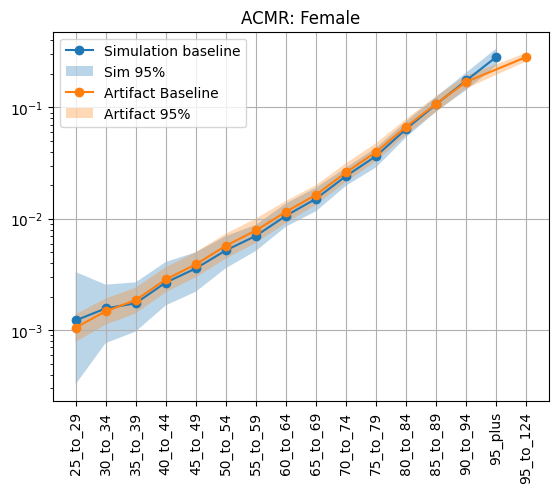

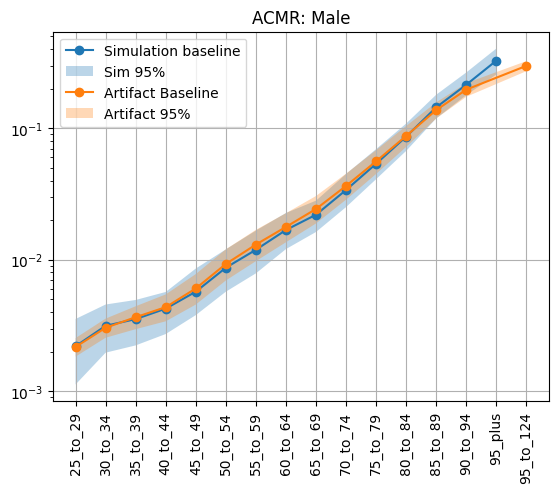

In [41]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'ACMR: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [42]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000001,6.866403e-07,0.000002,West_virginia,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000003,1.418090e-06,0.000004,West_virginia,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000004,2.212265e-06,0.000007,West_virginia,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000009,5.300502e-06,0.000013,West_virginia,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000013,8.012073e-06,0.000020,West_virginia,cause_specific_mortality_rate,45_to_49


In [43]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [44]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [45]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [46]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000006,0.0,0.000110
1,25_to_29,Male,0.000009,0.0,0.000107
2,30_to_34,Female,0.000002,0.0,0.000000
3,30_to_34,Male,0.000003,0.0,0.000042
4,35_to_39,Female,0.000006,0.0,0.000109


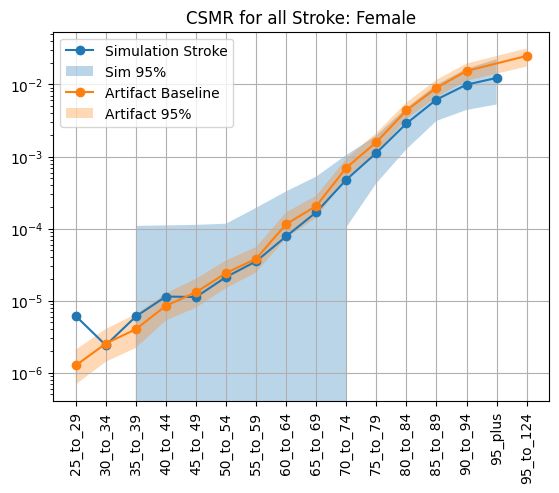

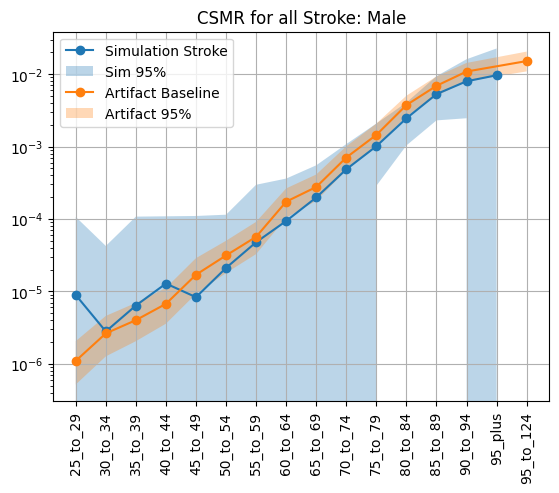

In [47]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
    plt.plot(subdata4['age'], subdata4['mean'], marker='o')
    plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
    subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for all Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.yscale('log')
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### IHD and HF Combined

In [48]:
art_csmr2 = load_artifact_data('cause', 'ischemic_heart_disease_and_heart_failure', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000587,0.000442,0.000767,West_virginia,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000702,0.000521,0.000910,West_virginia,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000803,0.000587,0.001058,West_virginia,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000848,0.000650,0.001109,West_virginia,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.001427,0.001148,0.001728,West_virginia,cause_specific_mortality_rate,45_to_49


In [49]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [50]:
IHD_HF_CSMR = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual') | (death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
IHD_HF_CSMR['mean_rate'] = IHD_HF_CSMR['value'] / IHD_HF_CSMR['ptvalue']
IHD_HF_CSMR_allyear = (IHD_HF_CSMR
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
IHD_HF_CSMR_allyear

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000854,0.000109,0.002874
1,25_to_29,Male,0.000907,0.000258,0.002111
2,30_to_34,Female,0.000933,0.000270,0.001757
3,30_to_34,Male,0.001204,0.000428,0.002342
...,...,...,...,...,...
26,90_to_94,Female,0.124941,0.095360,0.167085
27,90_to_94,Male,0.171018,0.114420,0.214000
28,95_plus,Female,0.167991,0.121654,0.236579
29,95_plus,Male,0.231853,0.157408,0.338039


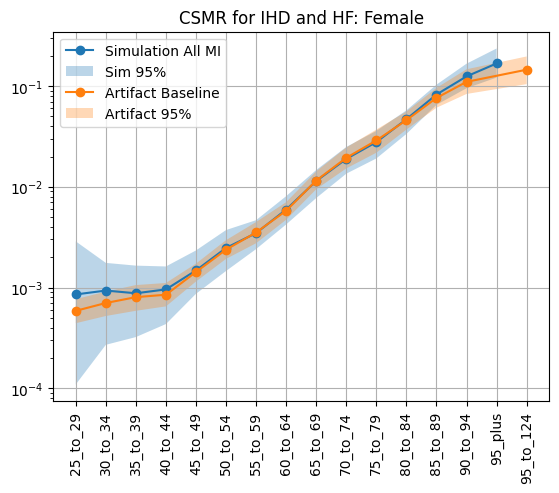

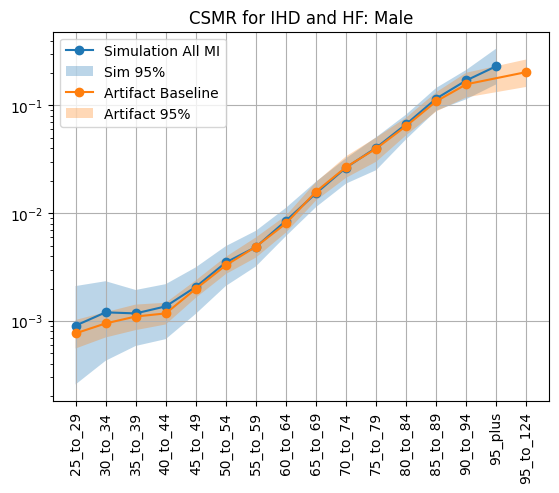

In [51]:
for sex in IHD_HF_CSMR_allyear.sex.unique():
    plt.figure() 
    subdata = IHD_HF_CSMR_allyear.loc[(IHD_HF_CSMR_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for IHD and HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [52]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000112,0.000045,0.000222,West_virginia,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000154,0.000084,0.000263,West_virginia,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000216,0.000116,0.000365,West_virginia,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000336,0.000211,0.000502,West_virginia,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000514,0.000295,0.000847,West_virginia,incidence_rate,45_to_49


In [53]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, 0.5, .975])
                 .filter(['50%', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,year,50%,2.5%,97.5%
0,25_to_29,Female,2023,0.000054,0.000000,0.001191
1,25_to_29,Female,2024,0.000214,0.000000,0.000761
2,25_to_29,Female,2025,0.000162,0.000000,0.001093
3,25_to_29,Female,2026,0.000218,0.000025,0.000959
4,25_to_29,Female,2027,0.000110,0.000000,0.000993


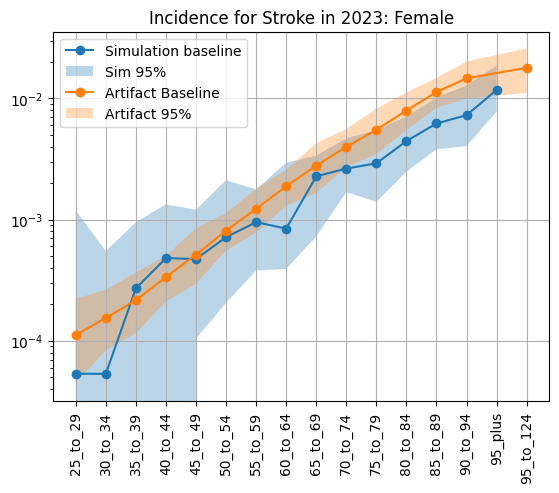

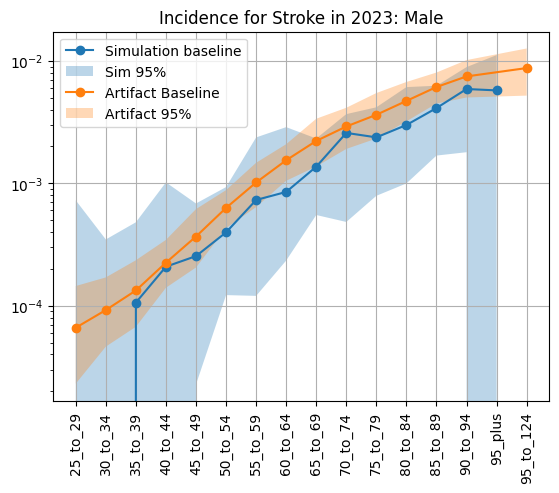

In [54]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for Stroke in 2023: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

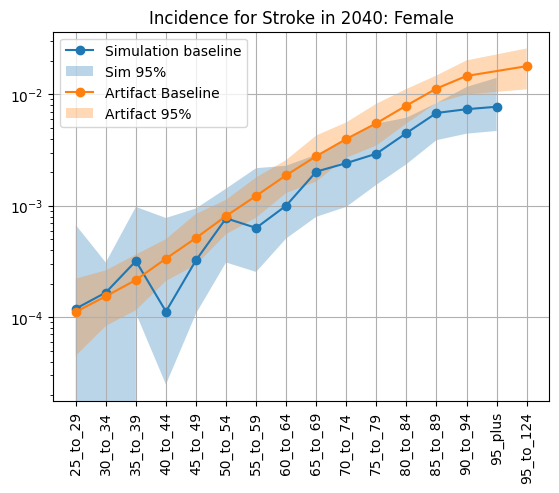

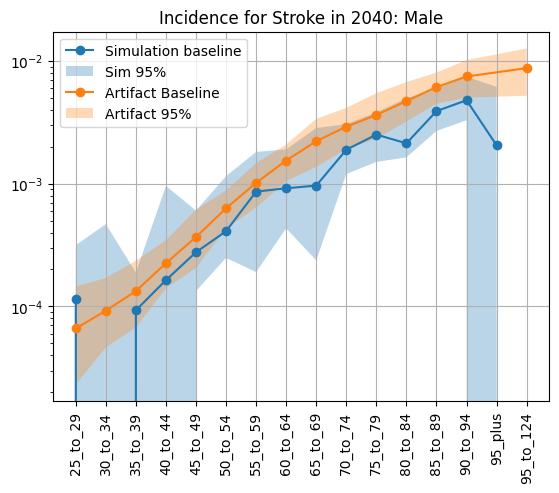

In [55]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for Stroke in 2040: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [56]:
art_inc_acute_MI = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000570,0.000373,0.000794,West_virginia,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000637,0.000424,0.000852,West_virginia,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000519,0.000362,0.000732,West_virginia,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000689,0.000518,0.000909,West_virginia,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.001147,0.000841,0.001484,West_virginia,incidence_rate,45_to_49


In [57]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_HF = tran_rate_MI_HF.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_rate_MI_HF = (tran_rate_MI_HF.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_rate_MI_HF.head()

mean  50%  2.5%     97.5%
age      sex                                      
25_to_29 Female  0.000000e+00  0.0   0.0  0.000000
         Male    0.000000e+00  0.0   0.0  0.000000
30_to_34 Female  0.000000e+00  0.0   0.0  0.000000
         Male    1.758485e-06  0.0   0.0  0.000006
35_to_39 Female  6.087228e-07  0.0   0.0  0.000005

In [58]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean       50%      2.5%     97.5%
age      sex                                           
25_to_29 Female  0.001097  0.000309  0.000091  0.005848
         Male    0.000547  0.000283  0.000045  0.002372
30_to_34 Female  0.001611  0.001986  0.000147  0.003175
         Male    0.001662  0.001708  0.000146  0.003669
35_to_39 Female  0.000635  0.000546  0.000312  0.001477

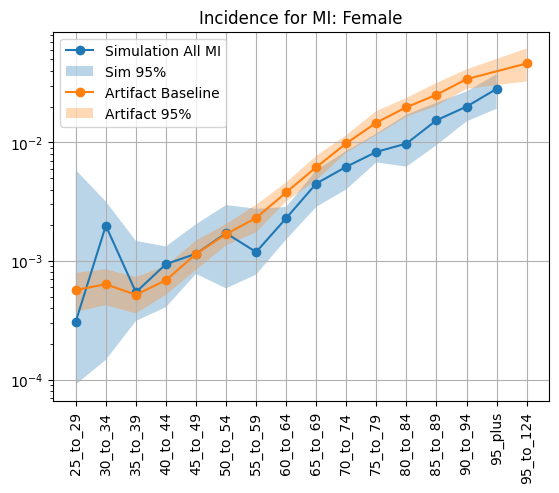

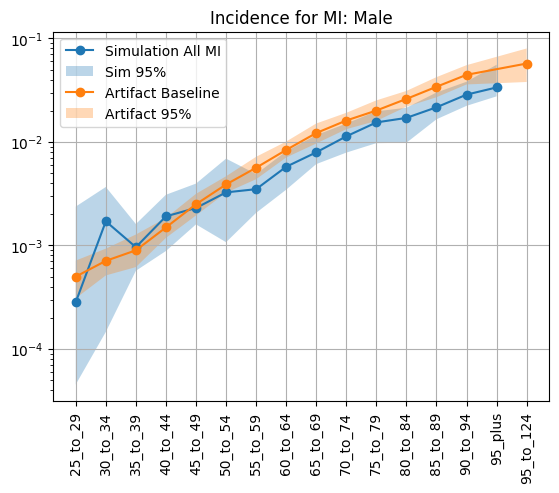

In [59]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['50%'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure IHD

In [60]:
art_inc_HF_IHD = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'incidence_rate')
art_inc_HF_IHD['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_IHD.age_start,art_inc_HF_IHD.age_end)]
art_inc_HF_IHD.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000074,0.000054,0.000098,West_virginia,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000105,0.000079,0.000136,West_virginia,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000103,0.000068,0.000150,West_virginia,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000214,0.000160,0.000281,West_virginia,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000572,0.000466,0.000692,West_virginia,incidence_rate,45_to_49


In [61]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF_IHD = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_IHD = tran_rate_HF_IHD.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_IHD_allyear = (tran_rate_HF_IHD.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_IHD_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 Female  0.000081  0.000040  0.000115
         Male    0.000151  0.000095  0.000196
30_to_34 Female  0.000119  0.000070  0.000166
         Male    0.000181  0.000121  0.000247
35_to_39 Female  0.000096  0.000050  0.000132

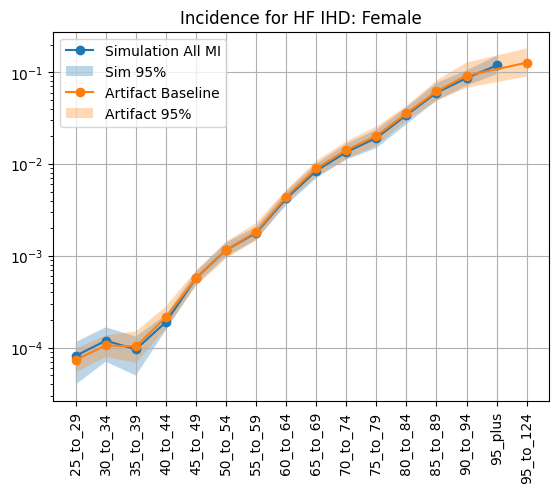

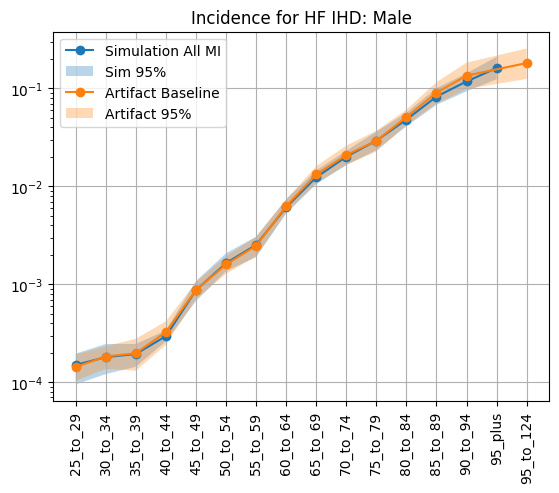

In [62]:
for sex in tran_rate_HF_IHD_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_IHD_allyear.loc[(tran_rate_HF_IHD_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_IHD.loc[(art_inc_HF_IHD.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure Residual

In [63]:
art_inc_HF_resid = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
art_inc_HF_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_resid.age_start,art_inc_HF_resid.age_end)]
art_inc_HF_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000628,0.000459,0.000832,West_virginia,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000582,0.000437,0.000748,West_virginia,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000397,0.000262,0.000578,West_virginia,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000660,0.000493,0.000864,West_virginia,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.001244,0.001012,0.001505,West_virginia,incidence_rate,45_to_49


In [64]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF_resid = tran.loc[(tran['transition'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_resid = tran_rate_HF_resid.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_resid_allyear = (tran_rate_HF_resid.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_resid_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 Female  0.000623  0.000498  0.000766
         Male    0.000839  0.000588  0.001039
30_to_34 Female  0.000619  0.000544  0.000749
         Male    0.000747  0.000575  0.000831
35_to_39 Female  0.000386  0.000296  0.000467

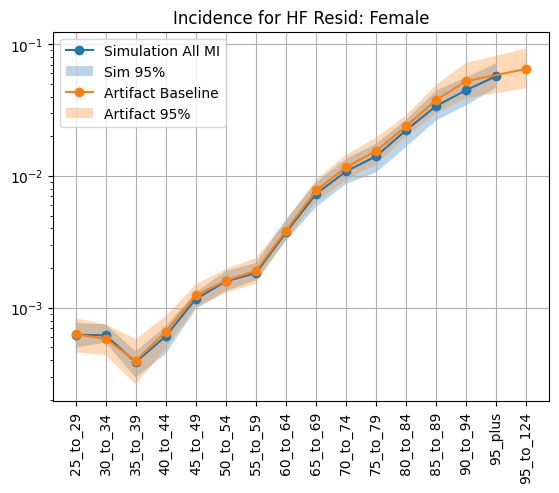

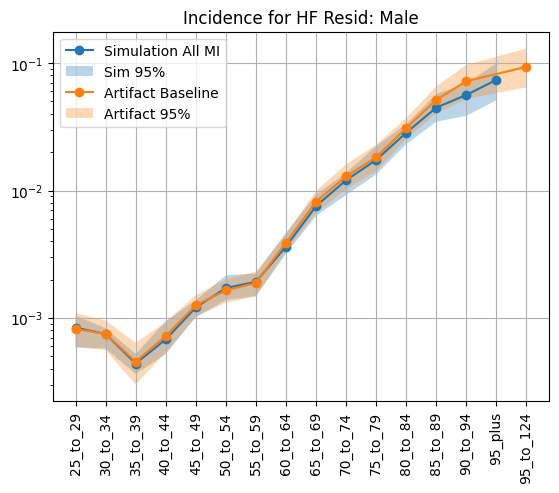

In [65]:
for sex in tran_rate_HF_resid_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_resid_allyear.loc[(tran_rate_HF_resid_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_resid.loc[(art_inc_HF_resid.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF Resid: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Matches the artifact but the artifact looks weird for the youngest folks 

#### Prevalence Rates

In [66]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [67]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.004179,0.003100,0.005270,West_virginia,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.005188,0.003968,0.006603,West_virginia,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.006654,0.005200,0.008740,West_virginia,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.008788,0.006745,0.011639,West_virginia,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.012181,0.009361,0.015950,West_virginia,prevalence,45_to_49


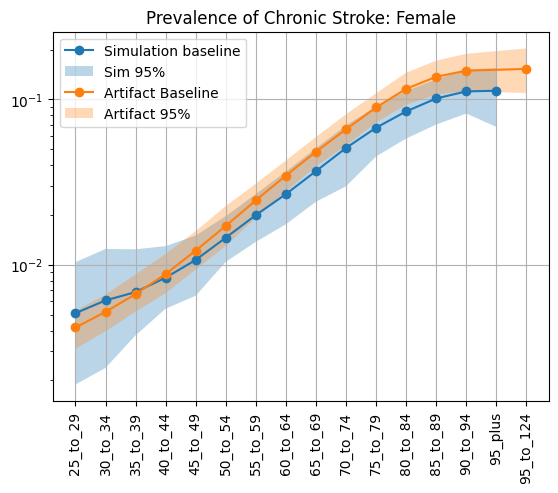

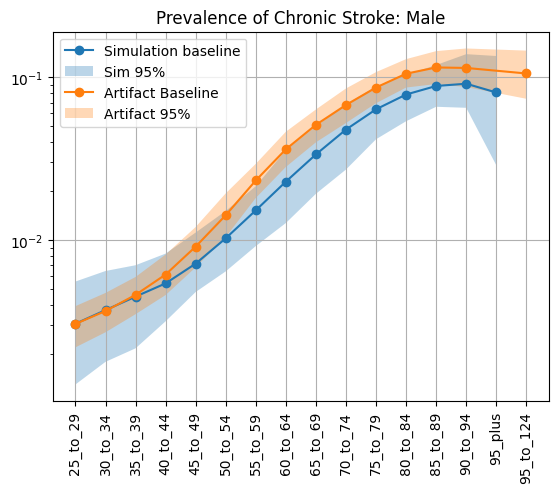

In [68]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [69]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [70]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

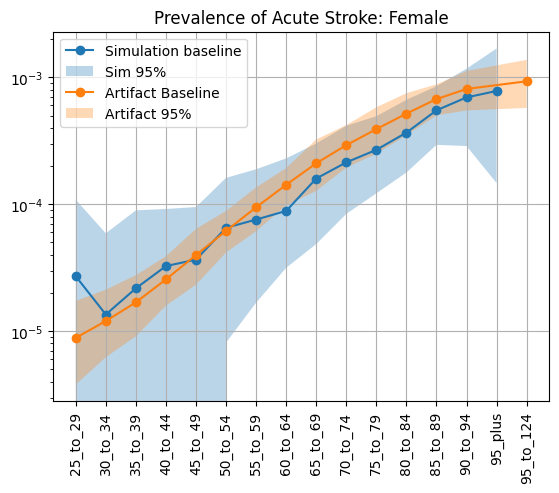

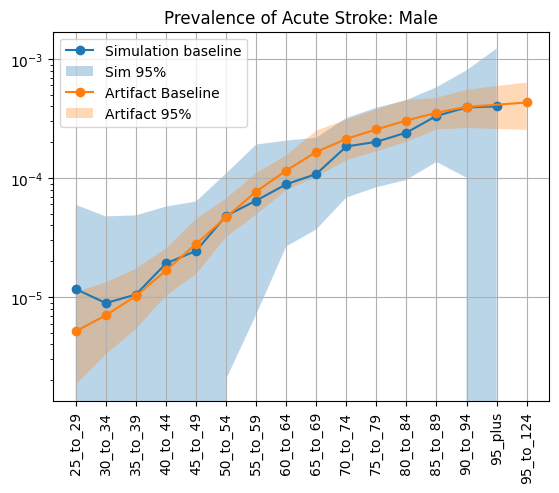

In [71]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [72]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.001273,0.000926,0.001663,West_virginia,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.002648,0.001906,0.003432,West_virginia,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.004281,0.003312,0.005342,West_virginia,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.006169,0.004843,0.007692,West_virginia,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.008474,0.006617,0.010523,West_virginia,prevalence,45_to_49


In [73]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.002588,0.000497,0.009386
1,25_to_29,Female,2024,0.003035,0.000515,0.011521
2,25_to_29,Female,2025,0.003560,0.000648,0.013491
3,25_to_29,Female,2026,0.003965,0.000661,0.015645
4,25_to_29,Female,2027,0.004358,0.000611,0.017605


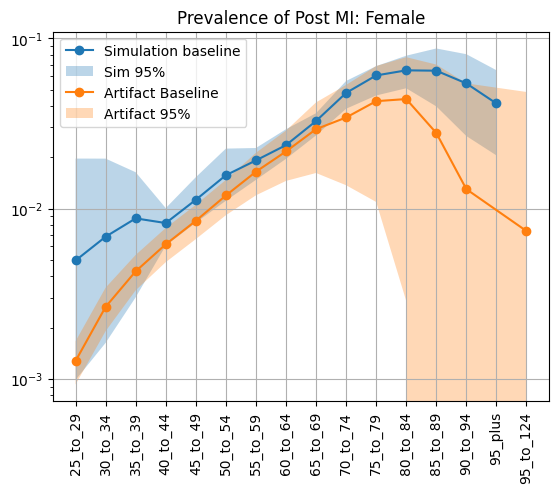

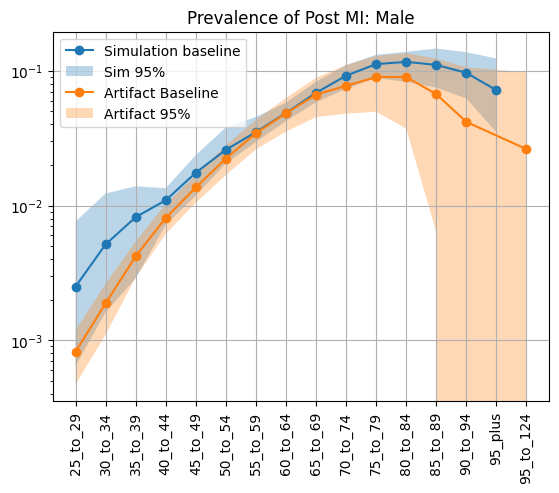

In [74]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex) & (prev_post_MI_sum_allyear.year == 2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [75]:
## 2023 looks pretty good but 2040 looks pretty bad 

#### Prevalence of Acute MI

In [76]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000036,0.000024,0.000049,West_virginia,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.000045,0.000030,0.000060,West_virginia,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.000038,0.000027,0.000052,West_virginia,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.000046,0.000034,0.000063,West_virginia,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.000077,0.000058,0.000098,West_virginia,prevalence,45_to_49


In [77]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000084,0.0,0.000561
1,25_to_29,Male,0.000042,0.0,0.000236
2,30_to_34,Female,0.000123,0.0,0.000288
3,30_to_34,Male,0.000127,0.0,0.000315
4,35_to_39,Female,0.000048,0.0,0.000139


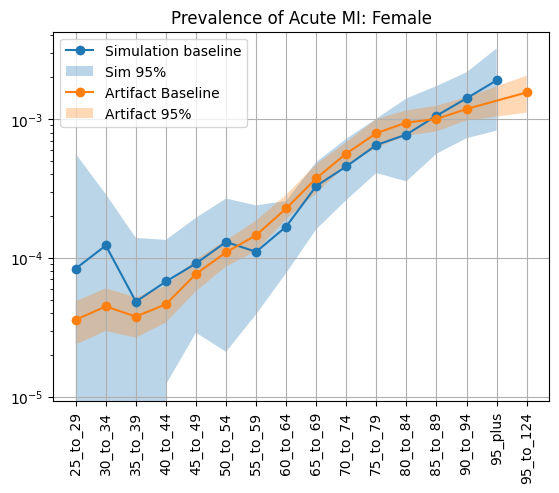

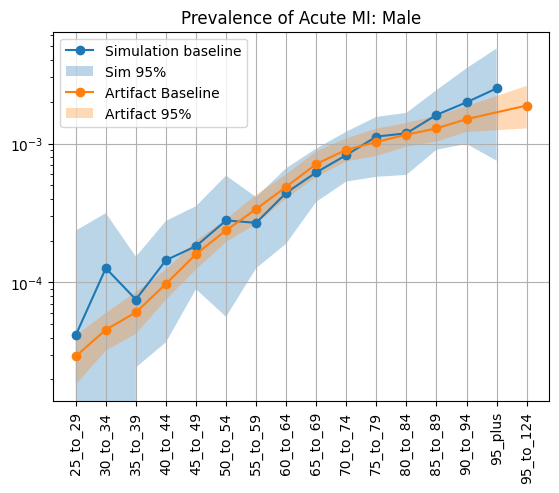

In [78]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Prevalence of Heart Failure IHD

In [79]:
art_prev_hf_ihd = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'prevalence')
art_prev_hf_ihd['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_ihd.age_start,art_prev_hf_ihd.age_end)]
art_prev_hf_ihd.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000294,0.000221,0.000382,West_virginia,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.000630,0.000466,0.000839,West_virginia,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.000816,0.000633,0.001041,West_virginia,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.000894,0.000724,0.001112,West_virginia,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.001849,0.001592,0.002159,West_virginia,prevalence,45_to_49


In [80]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_IHD['rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_IHD_allyear = (prev_HF_IHD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_IHD_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000259,0.000000,0.000592
1,25_to_29,Male,0.000482,0.000088,0.001041
2,30_to_34,Female,0.000490,0.000135,0.000951
3,30_to_34,Male,0.000812,0.000303,0.001594
4,35_to_39,Female,0.000645,0.000206,0.001399


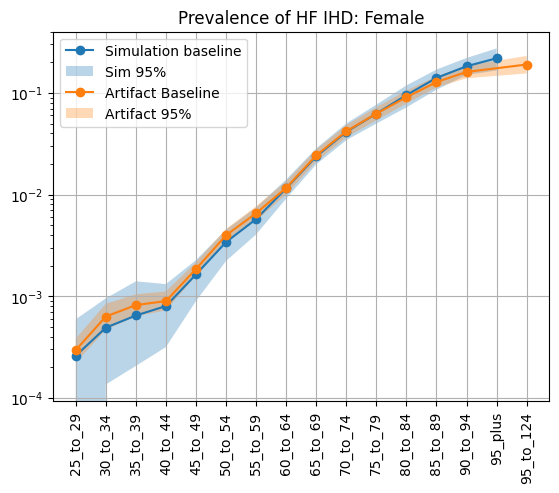

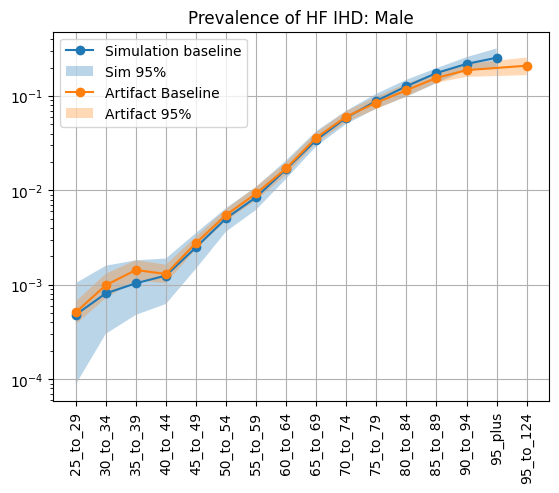

In [81]:
for sex in prev_HF_IHD_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_IHD_allyear.loc[(prev_HF_IHD_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_ihd.loc[(art_prev_hf_ihd.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Prevalence of Heart Failure Residual

In [82]:
art_prev_hf_resid = load_artifact_data('cause', 'heart_failure_residual', 'prevalence')
art_prev_hf_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_resid.age_start,art_prev_hf_resid.age_end)]
art_prev_hf_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.002506,0.001884,0.003250,West_virginia,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.003466,0.002565,0.004620,West_virginia,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.003132,0.002427,0.003996,West_virginia,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.002734,0.002214,0.003401,West_virginia,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.003987,0.003432,0.004657,West_virginia,prevalence,45_to_49


In [83]:
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'heart_failure_residual')].reset_index()
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_resid['rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_resid_allyear = (prev_HF_resid
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_resid_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.002691,0.001689,0.003906
1,25_to_29,Male,0.003157,0.001807,0.004665
2,30_to_34,Female,0.003553,0.002456,0.005115
3,30_to_34,Male,0.004050,0.002330,0.005848
4,35_to_39,Female,0.003403,0.002054,0.005011


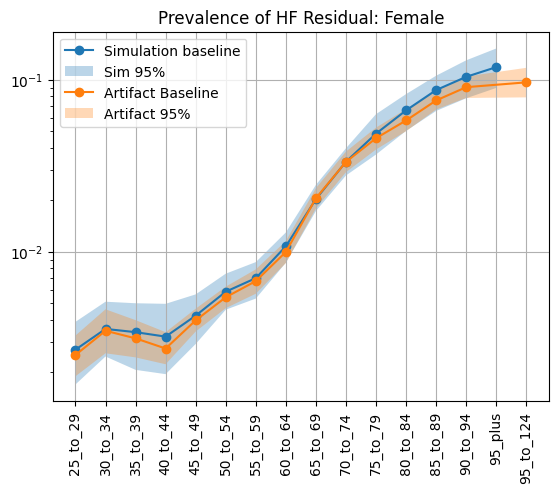

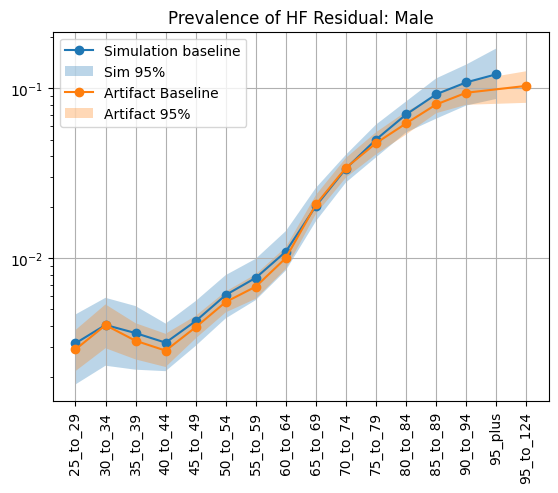

In [84]:
for sex in prev_HF_resid_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_resid_allyear.loc[(prev_HF_resid_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_resid.loc[(art_prev_hf_resid.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF Residual: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Excess Mortality Rate

#### Acute Stroke

In [85]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.301810,0.208573,0.424400,West_virginia,excess_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.285222,0.194919,0.412874,West_virginia,excess_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.316525,0.228342,0.427162,West_virginia,excess_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.314965,0.230045,0.431201,West_virginia,excess_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.280542,0.199827,0.387630,West_virginia,excess_mortality_rate,45_to_49


In [86]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.163247,0.0,1.659698
1,25_to_29,Male,1.095325,0.0,13.044643
2,30_to_34,Female,0.220312,0.0,1.808462
3,30_to_34,Male,0.263916,0.0,3.112926
4,35_to_39,Female,0.268556,0.0,4.348214


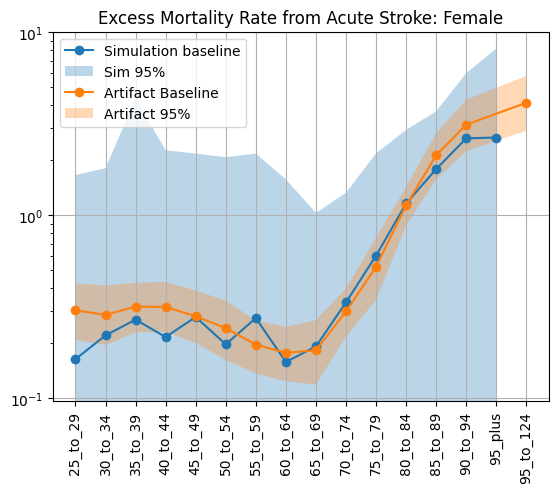

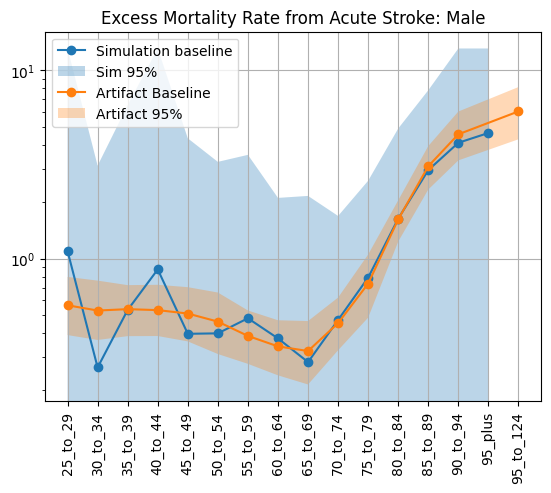

In [87]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [88]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [89]:
chronic = per_time_state.loc[(per_time_state['state'] == 'chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000000,0.0,0.0
1,25_to_29,Male,0.000000,0.0,0.0
2,30_to_34,Female,0.000000,0.0,0.0
3,30_to_34,Male,0.000224,0.0,0.0
4,35_to_39,Female,0.000000,0.0,0.0


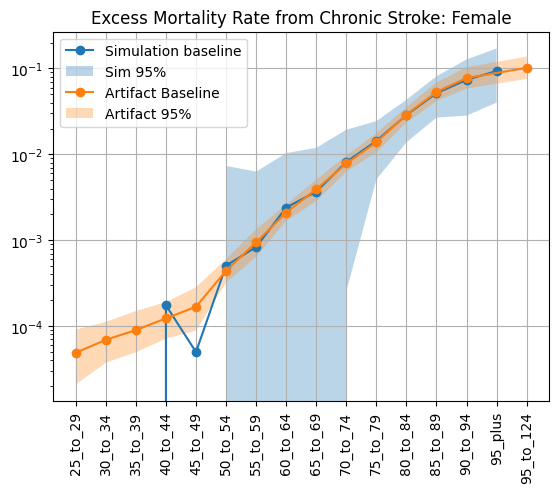

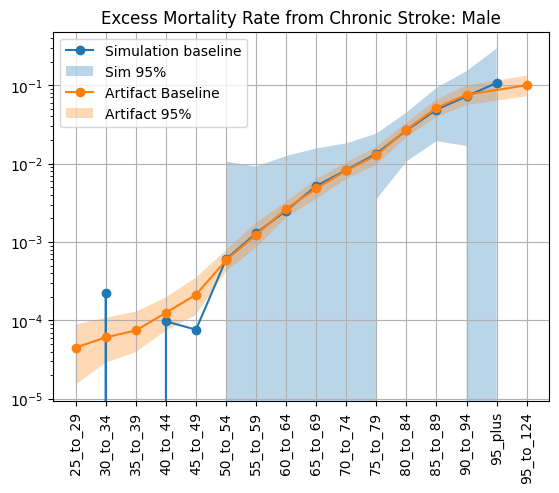

In [90]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [91]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [92]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'acute_myocardial_infarction'))].reset_index()
acute_MI_EMR = acute_MI_EMR.groupby(['age','year','sex','input_draw']).ptvalue.sum().reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.groupby(['age','year','sex','input_draw']).value.sum().reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.merge(acute_MI_EMR[['age','year','sex','input_draw','ptvalue']], on=['age','year','sex','input_draw'])
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_MI_emr_rate_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,2.545661,0.000000,11.479286
1,25_to_29,Female,2024,4.644809,0.563657,11.740179
2,25_to_29,Female,2025,1.733288,0.000000,4.348214
3,25_to_29,Female,2026,2.305867,0.000000,6.196205
4,25_to_29,Female,2027,1.460344,0.000000,5.759333


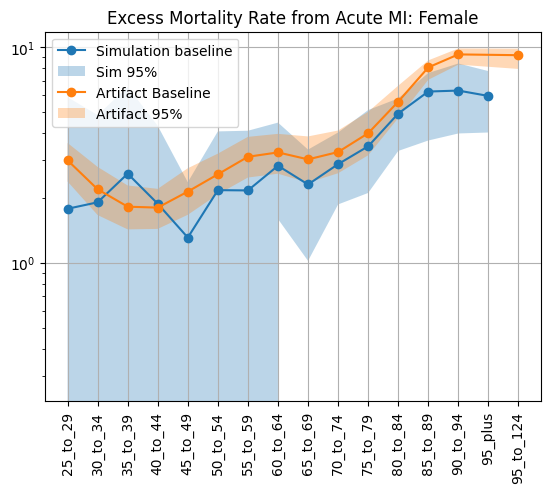

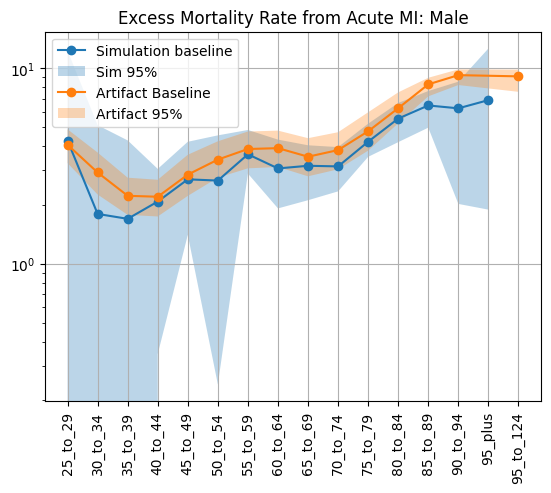

In [93]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex) & (acute_MI_emr_rate_allyear.year==2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [94]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.038699,0.0,0.178837
1,25_to_29,Male,0.044518,0.0,0.190045
2,30_to_34,Female,0.025166,0.0,0.099531
3,30_to_34,Male,0.029092,0.0,0.103970
4,35_to_39,Female,0.015023,0.0,0.055252


In [95]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

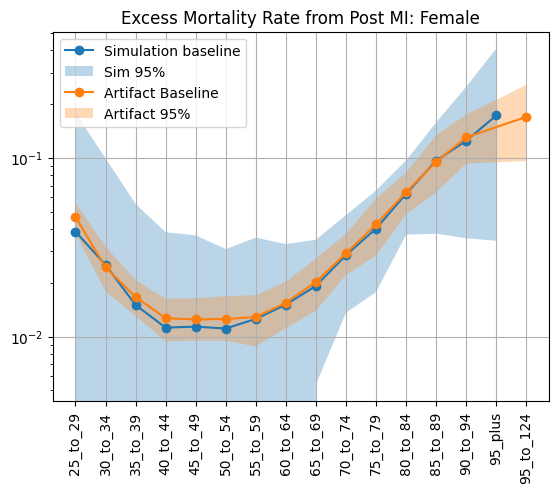

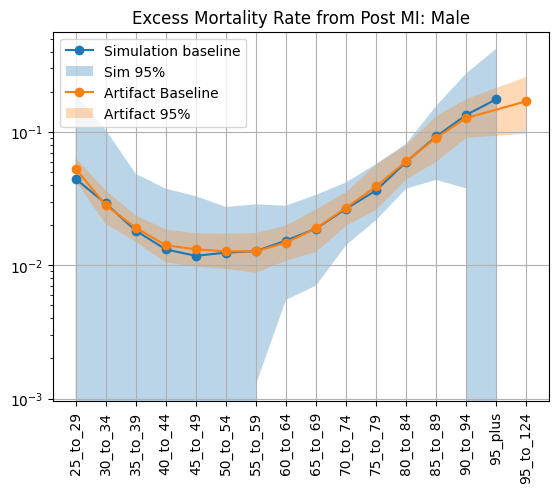

In [96]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 